# Deep embedded clustering

## Library and module imports 

In [89]:
#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Deep learning libraries
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from torch.utils.data import DataLoader, TensorDataset

In [44]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

## Importing Covariates dataframe

In [45]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df.head()

,MunicipalityNumber,MunicipalityName,urban_typo,mountain_type,mountain_binary,Population,language,Canton,Yes [nbr],No [nbr],...,PES,Small right-wing parties,Municipal_rev [CHF],revenue_per_capita [CHF],elec_consumption_households_mwh_per_year_per_capita,elec_consumption_households_mwh_per_year,elec_consumption_mwh_per_year_per_capita,elec_consumption_mwh_per_year,mean_price (cts/kWh),std_price (cts/kWh)
0,1.0,Aeugst am Albis,Low-density peri-urban municipality (23),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,1998.0,german,Zürich,444.0,335.0,...,298.149915,75.687016,109921000.0,NaN,2.9119,5811,4.4623,8905,26.231762,2.464933
1,2.0,Affoltern am Albis,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,12859.0,german,Zürich,1884.0,1260.0,...,1549.017114,191.375321,435719400.0,80080.757214,1.6492,21056,4.1840,53420,26.231762,2.464933
2,3.0,Bonstetten,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,5678.0,german,Zürich,1197.0,706.0,...,689.174556,77.173402,251102000.0,99960.987261,1.7356,9827,2.8006,15857,26.231762,2.464933
3,4.0,Hausen am Albis,Medium-density peri-urban municipality (22),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3974.0,german,Zürich,764.0,555.0,...,628.072197,60.419112,165486900.0,100968.212325,2.3004,9128,3.9176,15545,26.231762,2.464933
4,5.0,Hedingen,Urban municipality in a large agglomeration (11),Moyen-pays - Rhin supérieur (1),Communes hors des régions de montagne,3963.0,german,Zürich,809.0,580.0,...,466.535182,82.008137,177331200.0,106826.024096,2.1157,8335,5.3155,20941,26.231762,2.464933


## Transforming categorical columns into integer columns

In [54]:
print("transforming dataframe...")
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "Canton", "mountain_binary"])
print(categorical_columns)

# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
#print(encoded_categorical)

# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "Canton", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical.astype(int)], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
print(transformed_df.dtypes) # Display the data types of each column
transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]]=transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].astype(float)
print("data type of the modified elec columns:\n", transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].dtypes)
transformed_df.to_csv("../../data/cleaned_data/numeric_covariates.csv")

transforming dataframe...
Index(['urban_typo', 'mountain_type', 'language'], dtype='object')
Transformed DataFrame:
Population                                                                float64
Yes [nbr]                                                                 float64
No [nbr]                                                                  float64
0-19 years                                                                float64
20-64 years                                                               float64
65 years or older                                                         float64
Private households                                                        float64
Housing and infrastructure area (%)                                       float64
Total employment                                                          float64
Primary sector                                                            float64
Secondary sector                                                

## Removing NANs and estimating missing values

In [55]:
# Verifying that Nan values have correctly been removed
print(transformed_df.isna().sum())  # Inspect the first few rows

print(transformed_df.isna().any(axis=1).sum())  # take a look at each row at once
correctable_columns = transformed_df.columns.drop(
    [
    "PLR", 
    "PDC", 
    "PS", 
    "UDC", 
    "PEV/PCS", 
    "PVL", 
    "PBD", 
    "PST/Sol.", 
    "PES", 
    "Small right-wing parties", 
    "Primary sector", 
    "Secondary sector", 
    "Tertiary sector", 
    ]
)
processed_transformed_df = transformed_df.copy()
processed_transformed_df[correctable_columns] = processed_transformed_df[correctable_columns].apply(pd.to_numeric, errors='coerce').fillna("mean")


processed_transformed_df = processed_transformed_df.apply(pd.to_numeric, errors='coerce').fillna(0) # in case their are NANs remaining
print(processed_transformed_df.isna().sum())  # Inspect the first few rows


Population                                                                   1
Yes [nbr]                                                                    5
No [nbr]                                                                     5
0-19 years                                                                   1
20-64 years                                                                  1
65 years or older                                                            1
Private households                                                           1
Housing and infrastructure area (%)                                          1
Total employment                                                            88
Primary sector                                                              32
Secondary sector                                                            55
Tertiary sector                                                              6
New housing units built per 1000 inhabitants        

In [56]:
processed_transformed_df.sample(5)

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
1426,4609.0,596.0,595.0,1000.0,2778.0,677.0,1804.0,78.857579,1454.0,83.0,...,0,0,0,0,0,1,0,1,0,0
2075,16690.0,2539.0,935.0,2975.0,8515.0,2692.0,5638.0,1019.331250,5862.0,14.0,...,0,0,0,0,1,0,1,0,0,0
1032,1012.0,166.0,125.0,191.0,496.0,164.0,340.0,10.581217,161.0,62.0,...,0,0,0,0,1,0,0,1,0,0
1280,8060.0,1389.0,666.0,1609.0,4592.0,1412.0,3295.0,345.763544,4931.0,10.0,...,0,0,0,0,1,0,0,1,0,0
246,1264.0,168.0,217.0,238.0,693.0,265.0,539.0,5.753191,476.0,57.0,...,0,0,0,1,0,0,1,0,0,0


## Scaling the dataframe

In [57]:
# Creating a copy of the dataframe
scaled_processed_transformed_df = processed_transformed_df.copy()

# Step 1: Identify continuous variables
# Let's assume continuous variables are of float type. You can adjust this based on your dataset.
continuous_columns = scaled_processed_transformed_df.select_dtypes(include=['float64']).columns

# Step 2: Scale only continuous variables
scaler = StandardScaler()

# Scale only the continuous columns
scaled_processed_transformed_df[continuous_columns] = scaler.fit_transform(scaled_processed_transformed_df[continuous_columns])
scaled_processed_transformed_df.sample(5)

scaled_processed_transformed_df.to_csv("../../data/cleaned_data/calculable_covariates.csv")

## Checking for relationship types between covariates (non linear and linear)

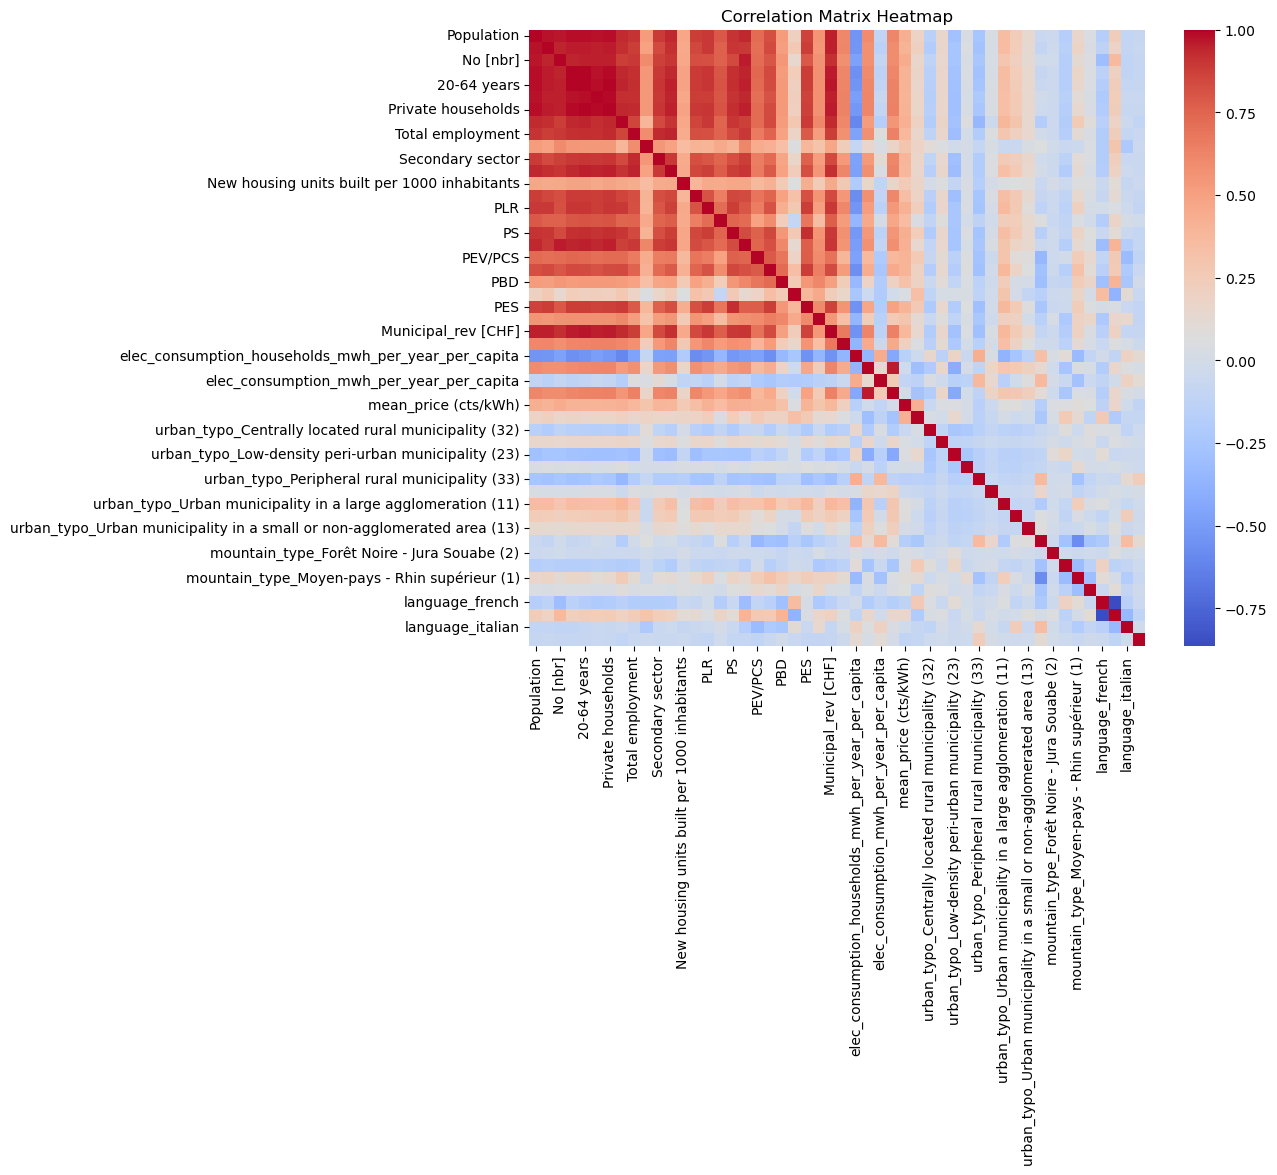

In [38]:
# Spearman's correlaiton coefficient 
correlation_matrix = processed_transformed_df.corr(method='spearman')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


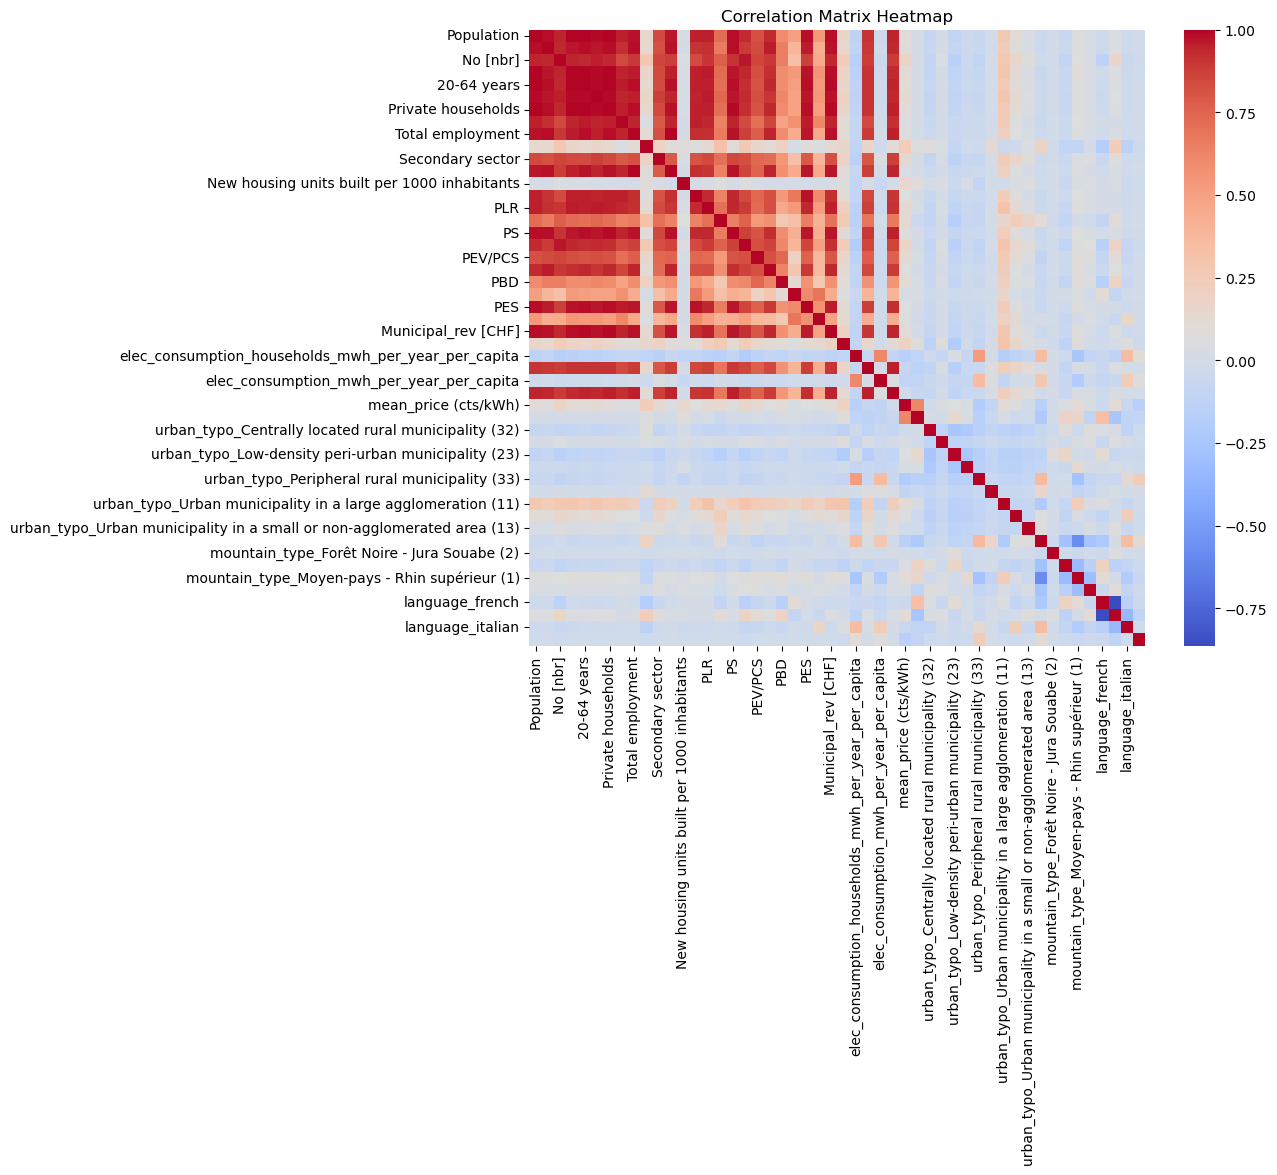

In [39]:
# Spearman's correlaiton coefficient 
correlation_matrix = processed_transformed_df.corr(method='pearson')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The data seems to hold non linear relationships > which leads us to applying deep embedded clusteing coupled to DBSCAN rather than PCA Analysis with K-means clustering

## Model definition

### Defintion of a simple model

In [116]:
# copying dataframe
df = scaled_processed_transformed_df.copy()

# Step 4: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 5: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 6: Instantiate the Autoencoder
input_dim = df.shape[1]
print(f"\nInput dim : {input_dim}\n")
encoding_dim = 5 # Latent space dimension (you can change this)
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 7: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 8: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 9: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

print("\nModel trained!")



Input dim : 50

Running Neural network...
Epoch [10/100], Loss: 0.1445
Epoch [20/100], Loss: 0.0971
Epoch [30/100], Loss: 0.0645
Epoch [40/100], Loss: 0.1897
Epoch [50/100], Loss: 0.1214
Epoch [60/100], Loss: 0.1106
Epoch [70/100], Loss: 0.0795
Epoch [80/100], Loss: 0.1699
Epoch [90/100], Loss: 0.0644
Epoch [100/100], Loss: 0.1159

Model trained!


### Defintion of a more complex model

In [126]:
# Assuming you have a DataFrame of covariates called df
df = scaled_processed_transformed_df.copy()

# Step 3: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder with Batch Normalization and Dropout
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 4: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 5: Instantiate the Autoencoder
input_dim = df.shape[1]  # Number of features in the dataset
encoding_dim = 4  # Increased latent space dimension
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 7: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 8: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

print("\nModel trained !")


Running Neural network...
Epoch [10/100], Loss: 0.1397
Epoch [20/100], Loss: 0.1415
Epoch [30/100], Loss: 0.1737
Epoch [40/100], Loss: 0.0782
Epoch [50/100], Loss: 0.1434
Epoch [60/100], Loss: 0.2699
Epoch [70/100], Loss: 0.0980
Epoch [80/100], Loss: 0.1892
Epoch [90/100], Loss: 0.2502
Epoch [100/100], Loss: 0.1655

Model trained !


## Analyzing latent space

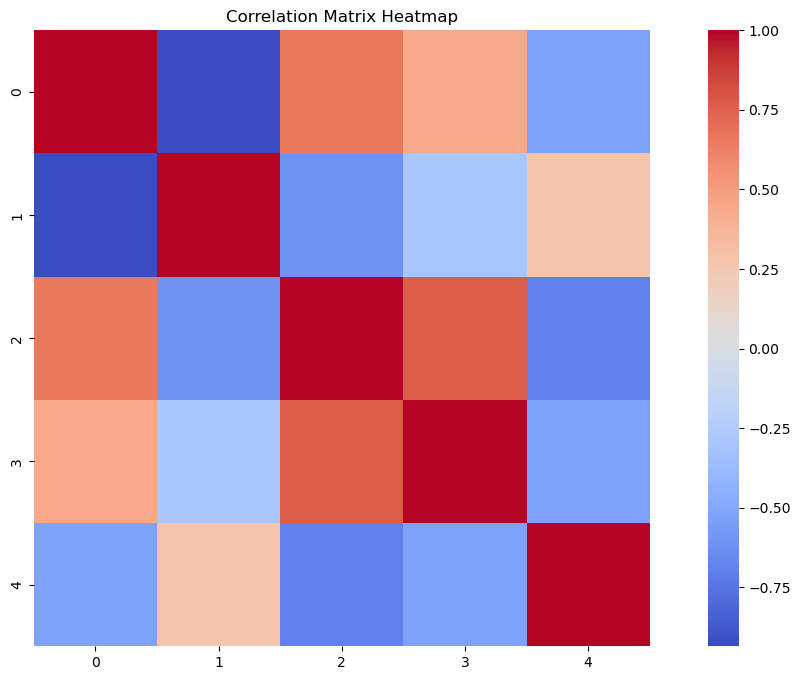

In [117]:
# Spearman's correlaiton coefficient 
correlation_matrix = np.corrcoef(X_encoded, rowvar=False)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

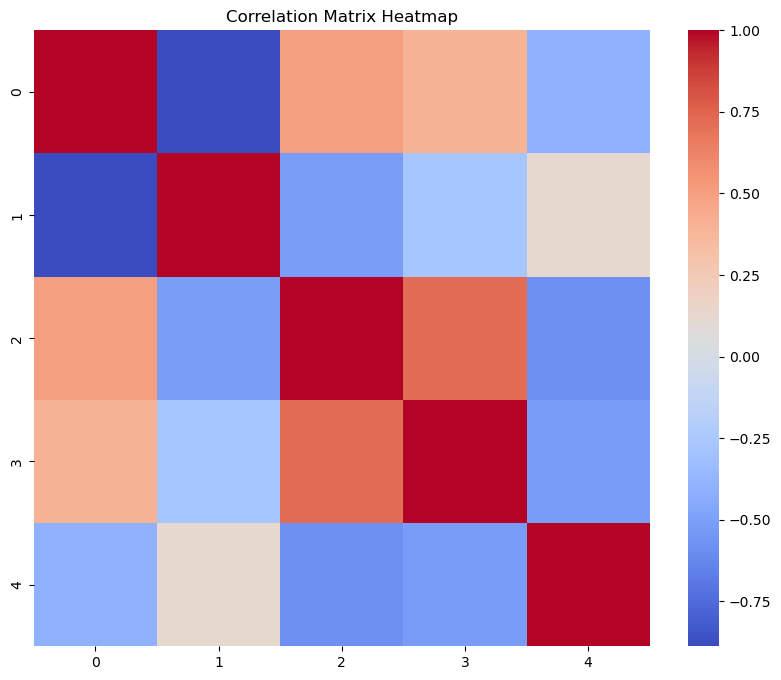

In [118]:
from scipy.stats import spearmanr

# Calculate the Spearman correlation matrix
corr, _ = spearmanr(X_encoded, axis=0)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## DBSCAN clustering

ep: 0.01
ms: 2
[-1  0  1  2  3  4]
ms: 3
[-1]
ms: 4
[-1]
ms: 5
[-1]
ms: 6
[-1]
ms: 7
[-1]
ms: 8
[-1]
ms: 9
[-1]
ms: 10
[-1]
ms: 11
[-1]
ms: 12
[-1]
ms: 13
[-1]
ms: 14
[-1]
ep: 0.09777777777777778
ms: 2
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182]
ms: 3
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 1

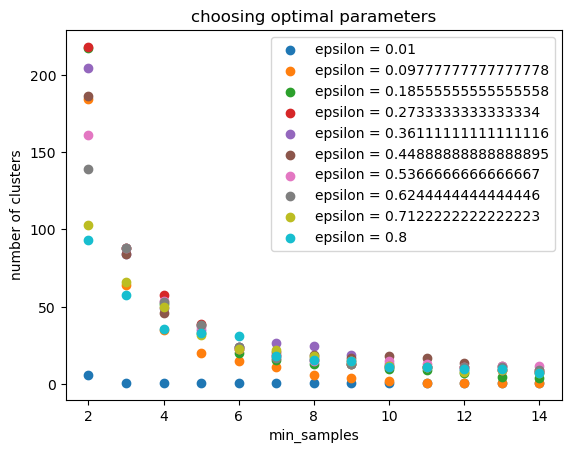

In [96]:
eps = np.linspace(0.01, 0.8, 10)
min_samples_array = np.arange(2, 15, 1)

for ep in eps:
    print("ep:", ep)
    clust_number_list = []
    for ms in min_samples_array:
        
        print("ms:", ms)
        # Step 9: Apply DBSCAN to the latent space
        dbscan_algo = DBSCAN(eps=ep, min_samples=ms)  # Adjust eps and min_samples as needed
        clusters = dbscan_algo.fit_predict(X_encoded)
        print(np.unique(clusters))
        clust_number_list.append(len(np.unique(clusters)))
    plt.scatter(min_samples_array, clust_number_list, label=f"epsilon = {ep}")
plt.xlabel("min_samples")
plt.ylabel("number of clusters")
plt.legend()
plt.title("choosing optimal parameters")
plt.show()

In [97]:

# Step 9: Apply DBSCAN to the latent space
dbscan = DBSCAN(eps=0.4, min_samples=14)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters)

Cluster labels: [ 0 -1  1 ... -1 -1 -1]


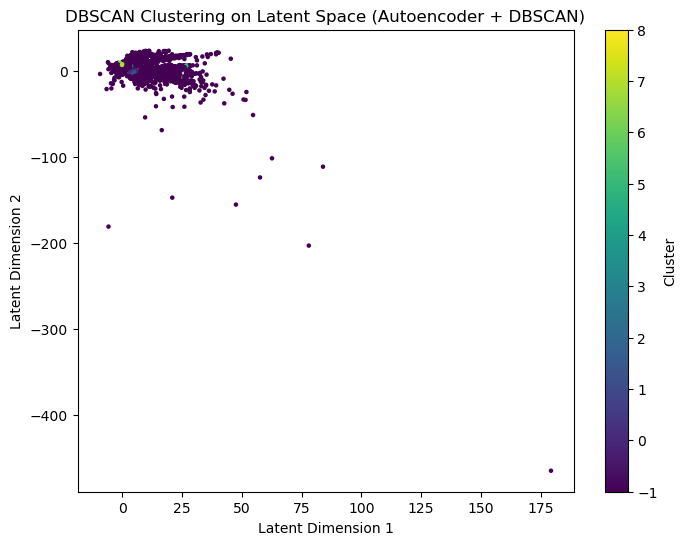

Silhouette Score: -0.31528785824775696
Davies-Bouldin Index: 1.6715848194989256
Cluster labels: [ 0 -1  1 ... -1 -1 -1]


In [98]:
# Step 11: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("DBSCAN Clustering on Latent Space (Autoencoder + DBSCAN)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 12: Evaluate the clustering (optional)
silhouette_avg = silhouette_score(X_encoded, clusters)
print(f"Silhouette Score: {silhouette_avg}")

db_score = davies_bouldin_score(X_encoded, clusters)
print(f"Davies-Bouldin Index: {db_score}")

# Cluster and True Labels comparison (if you have labels)
print("Cluster labels:", clusters)

## K-Means Clustering

In [127]:
# Number of clusters to test
number_of_clusters = np.arange(2, 21)  # Clusters from 2 to 20

# Lists to store evaluation scores
silhouette_list = []
davies_bouldin_list = []

for num_clusters in number_of_clusters: 
    # Step 9: Apply K-Means to the latent space
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_encoded)

    # Step 11: Evaluate clustering performance
    silhouette_avg = silhouette_score(X_encoded, clusters)
    silhouette_list.append(silhouette_avg)

    davies_bouldin = davies_bouldin_score(X_encoded, clusters)
    davies_bouldin_list.append(davies_bouldin)


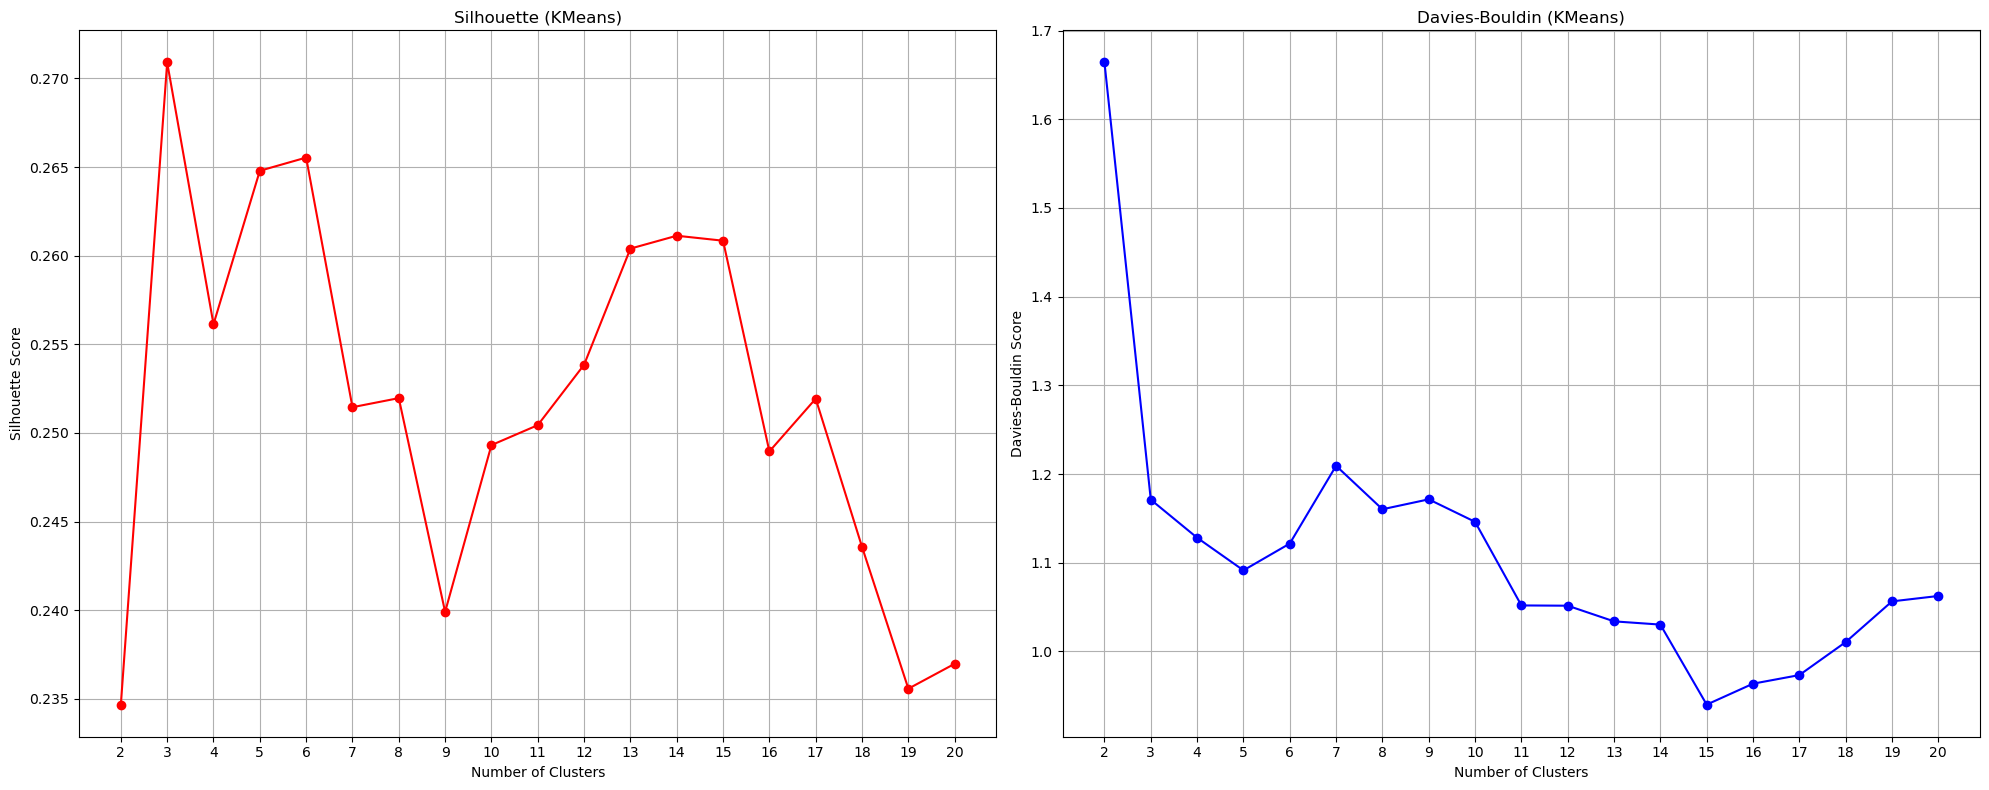

In [128]:
# Optional Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Silhouette scores plot
plt.grid()
axes[0].plot(number_of_clusters, silhouette_list, marker="o", color="red")
axes[0].set_title("Silhouette (KMeans)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_xticks(number_of_clusters)
axes[0].grid(True)


# Davies-Bouldin scores plot
plt.grid()
axes[1].plot(number_of_clusters, davies_bouldin_list, marker="o", color="blue")
axes[1].set_title("Davies-Bouldin (KMeans)")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Davies-Bouldin Score")
axes[1].set_xticks(number_of_clusters)
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [129]:
# Step 9: Apply K-Means to the latent space
num_clusters = 6  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters_vect = kmeans.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters_vect)

# Step 11: Evaluate clustering performance
silhouette_avg = silhouette_score(X_encoded, clusters_vect)
davies_bouldin = davies_bouldin_score(X_encoded, clusters_vect)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")

# Optional Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 4], X_encoded[:, 2], c=clusters_vect, cmap='rocket', s=50)
plt.title("K-Means Clustering on Latent Space (Autoencoder + K-Means)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

Cluster labels: [0 3 0 ... 5 5 5]
Silhouette Score: 0.2655
Davies-Bouldin Score: 1.1216


IndexError: index 4 is out of bounds for axis 1 with size 4

<Figure size 800x600 with 0 Axes>

In [75]:
transformed_df["type"] = clusters_vect

## Visualizing types

In [76]:
Covariates_trans_df = transformed_df.copy()
Covariates_trans_df.head()

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh,type
0,1998.0,444.0,335.0,392.0,1232.0,357.0,848.0,25.075949,442.0,39.0,...,0,0,0,1,0,0,1,0,0,0
1,12859.0,1884.0,1260.0,2481.0,7587.0,2235.0,5412.0,377.385470,6920.0,47.0,...,0,0,0,1,0,0,1,0,0,3
2,5678.0,1197.0,706.0,1317.0,3334.0,921.0,2327.0,86.126344,1014.0,34.0,...,0,0,0,1,0,0,1,0,0,3
3,3974.0,764.0,555.0,832.0,2244.0,675.0,1552.0,47.609905,1021.0,93.0,...,0,0,0,1,0,0,1,0,0,0
4,3963.0,809.0,580.0,817.0,2329.0,632.0,1580.0,74.868902,1478.0,29.0,...,0,0,0,1,0,0,1,0,0,3


In [77]:
typologies_df = Covariates_trans_df.groupby("type").mean()
typologies_df

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
type,,,,,,,,,,,,,,,,,,,,,
0,2336.852596,328.848739,342.890756,459.418760,1353.219430,426.685092,960.879397,36.641928,898.698467,77.491582,...,0.063652,0.103853,0.011725,0.087102,0.547739,0.246231,0.000000,1.000000,0.000000,0.000000
1,1323.208108,208.272973,133.964865,280.629730,754.640541,224.924324,528.710811,21.711673,552.126471,34.390710,...,0.024324,0.081081,0.000000,0.337838,0.545946,0.029730,0.875676,0.116216,0.008108,0.000000
2,202902.666667,38297.166667,11335.833333,35233.333333,130647.333333,31548.000000,94722.333333,12652.248515,208151.500000,143.666667,...,0.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.333333,0.666667,0.000000,0.000000
3,11438.547855,1681.250825,1085.524752,2213.943894,6731.326733,2074.897690,4862.663366,415.834819,6899.738983,78.430508,...,0.148515,0.181518,0.000000,0.026403,0.646865,0.138614,0.227723,0.762376,0.009901,0.000000
4,686.997151,88.845272,123.621777,130.068376,399.267806,144.159544,294.643875,3.145950,302.632530,56.255072,...,0.002849,0.868946,0.000000,0.122507,0.000000,0.008547,0.065527,0.794872,0.105413,0.034188
5,2597.719665,343.740586,346.887029,518.518828,1545.531381,497.447699,1106.267782,44.670375,1185.893805,91.991266,...,0.096234,0.941423,0.000000,0.012552,0.000000,0.046025,0.200837,0.481172,0.309623,0.008368
6,377.412879,55.750000,46.026515,81.704545,222.181818,65.753788,149.306818,5.470623,128.035019,15.643939,...,0.071698,0.124528,0.007547,0.215094,0.464151,0.177358,0.562264,0.415094,0.015094,0.003774


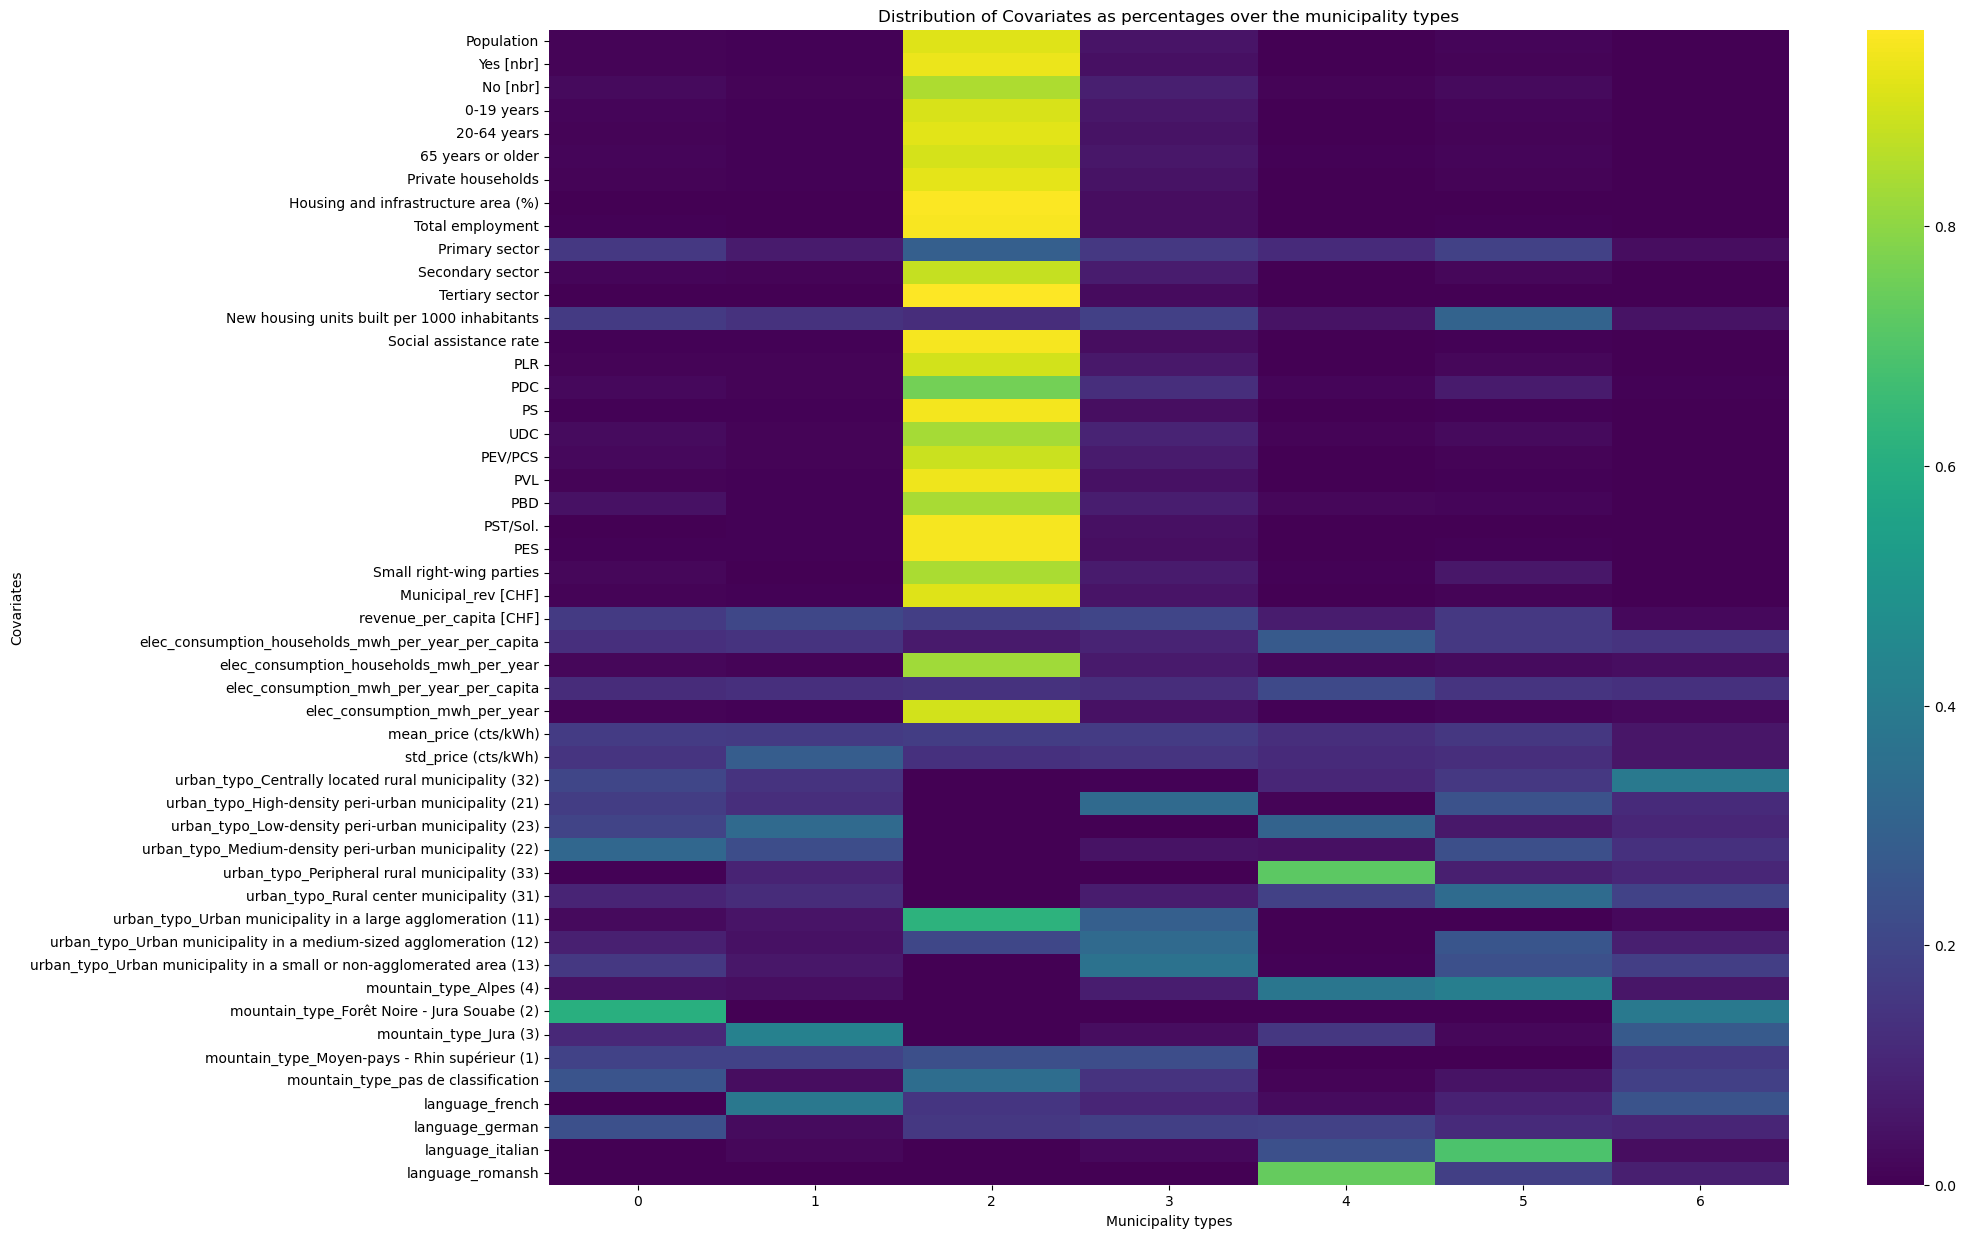

In [78]:
typologies_df_normalized = typologies_df.copy()
for col in typologies_df_normalized.columns:
    typologies_df_normalized[col] = typologies_df_normalized[col]/typologies_df_normalized[col].sum()

# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(typologies_df_normalized.T, annot=False, fmt='g', cmap='viridis', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types")
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

In [79]:
ratio_typologies_df = Covariates_trans_df.groupby("type").sum()

for col in ratio_typologies_df.columns:
    ratio_typologies_df[col] = ratio_typologies_df[col]/ratio_typologies_df[col].sum()

ratio_typologies_df

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
type,,,,,,,,,,,,,,,,,,,,,
0,0.185282,0.171665,0.258673,0.188961,0.180379,0.189704,0.178249,0.089270,0.119868,0.361814,...,0.281481,0.087324,0.777778,0.180556,0.383803,0.558935,0.000000,0.432922,0.000000,0.000000
1,0.065022,0.067609,0.062845,0.071536,0.062343,0.061977,0.060786,0.032783,0.042655,0.098939,...,0.066667,0.042254,0.000000,0.434028,0.237089,0.041825,0.526829,0.031182,0.024793,0.000000
2,0.161684,0.201598,0.086235,0.145644,0.175023,0.140967,0.176599,0.309794,0.283780,0.006776,...,0.000000,0.000000,0.000000,0.000000,0.004695,0.007605,0.003252,0.002901,0.000000,0.000000
3,0.460300,0.446934,0.417024,0.462166,0.455394,0.468202,0.457826,0.514184,0.462493,0.181866,...,0.333333,0.077465,0.000000,0.027778,0.230047,0.159696,0.112195,0.167513,0.024793,0.000000
4,0.032025,0.027204,0.054701,0.031453,0.031291,0.037683,0.032136,0.004506,0.022830,0.152555,...,0.007407,0.429577,0.000000,0.149306,0.000000,0.011407,0.037398,0.202321,0.305785,0.800000
5,0.082455,0.072077,0.105115,0.085379,0.082474,0.088540,0.082156,0.043568,0.060898,0.165587,...,0.170370,0.316901,0.000000,0.010417,0.000000,0.041825,0.078049,0.083394,0.611570,0.133333
6,0.013233,0.012913,0.015406,0.014861,0.013097,0.012928,0.012248,0.005894,0.007477,0.032463,...,0.140741,0.046479,0.222222,0.197917,0.144366,0.178707,0.242276,0.079768,0.033058,0.066667


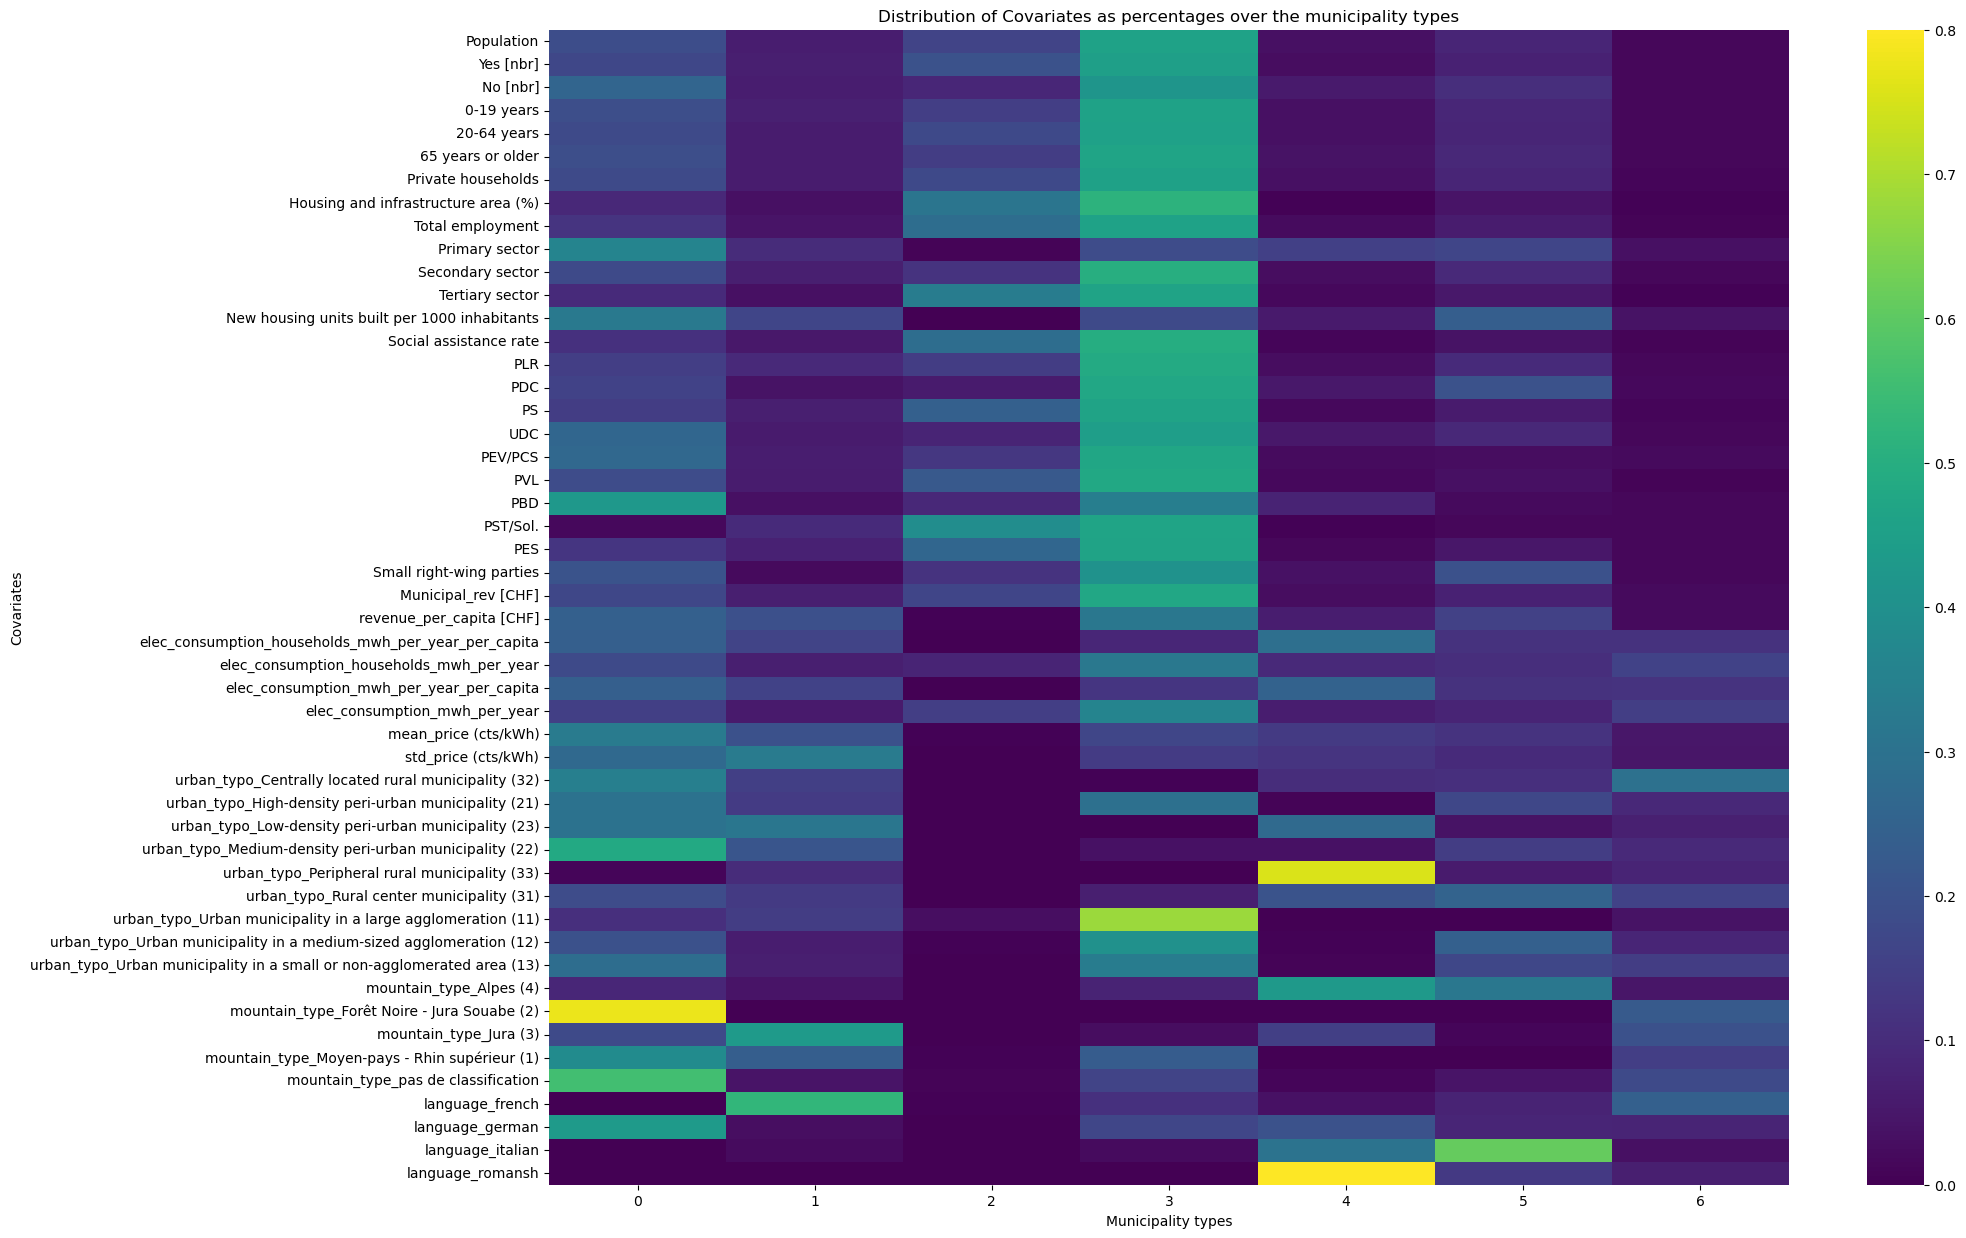

In [80]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(ratio_typologies_df.T, annot=False, fmt='g', cmap='viridis', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types")
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

In [ ]:
ratio_typologies_df.describe()

,Population,Yes [nbr],No [nbr],0-19 years,20-64 years,65 years or older,Private households,Housing and infrastructure area (%),Total employment,Primary sector,...,urban_typo_Urban municipality in a small or non-agglomerated area (13),mountain_type_Alpes (4),mountain_type_Forêt Noire - Jura Souabe (2),mountain_type_Jura (3),mountain_type_Moyen-pays - Rhin supérieur (1),mountain_type_pas de classification,language_french,language_german,language_italian,language_romansh
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,...,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
std,0.103893,0.097816,0.102939,0.105300,0.101574,0.106282,0.101966,0.122646,0.097591,0.090296,...,0.110571,0.143153,0.147558,0.249405,0.135580,0.140935,0.106293,0.091929,0.198829,0.242712
min,0.018193,0.019651,0.010722,0.015498,0.019854,0.017259,0.020250,0.010726,0.019910,0.001690,...,0.000000,0.000000,0.000000,0.000000,0.001174,0.000000,0.000000,0.000725,0.000000,0.000000
25%,0.035278,0.036102,0.036028,0.038514,0.034081,0.034509,0.033217,0.020092,0.027084,0.025707,...,0.011111,0.002113,0.000000,0.001736,0.001761,0.011407,0.012195,0.007252,0.000000,0.000000
50%,0.050541,0.043885,0.047884,0.051321,0.050057,0.049960,0.047870,0.024733,0.031620,0.066318,...,0.059259,0.022535,0.000000,0.013889,0.011737,0.022814,0.060163,0.065990,0.000000,0.000000
75%,0.112004,0.113305,0.084488,0.107145,0.115402,0.104791,0.113608,0.124219,0.141293,0.124289,...,0.137037,0.119718,0.166667,0.031250,0.148474,0.114068,0.107317,0.150109,0.024793,0.000000
max,0.375186,0.352574,0.365259,0.382066,0.365744,0.384428,0.366039,0.390032,0.314891,0.289970,...,0.362963,0.440845,0.444444,0.840278,0.384977,0.486692,0.318699,0.256708,0.603306,0.800000


## Importing PV data

In [81]:
Swiss_solar_potential = pd.read_csv("../../data/cleaned_data/Swiss_solar_potential.csv")

In [82]:
Swiss_solar_potential["type"]=clusters_vect
Swiss_solar_potential.sample()

,mun_name,canton_abr,pv_pot,pv_pot_reco,fpv_pot,fpv_pot_reco,roof_area,facade_area,total_power,total_energy,...,Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh,Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh,Scenario4_RoofsFacades_PotentialSolarElectricity_GWh,Scenario4_RoofsFacades_PotentialSolarHeat_GWh,Factsheet,Methodology,mun_id,type
1060,Ried-Brig,VS,1.540362e+07,1.363091e+07,1.013233e+07,6.220945e+06,132418.297359,196708.300802,1484.11,1484110.0,...,2.92,2.0,0.96,0.7,23.43,5.44,https://www.uvek-gis.admin.ch/BFE/storymaps/EC...,https://www.uvek-gis.admin.ch/BFE/redirect/sol...,6008,0


In [83]:
Swiss_solar_potential.columns

Index(['mun_name', 'canton_abr', 'pv_pot', 'pv_pot_reco', 'fpv_pot',
       'fpv_pot_reco', 'roof_area', 'facade_area', 'total_power',
       'total_energy', 'initial_power', 'total_potential',
       'recommended_potential', 'achieved_rp', 'achieved_tp', 'Canton',
       'Country', 'Scenario1_RoofsOnly_PotentialSolarElectricity_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month01_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month02_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month03_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month04_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month05_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month06_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month07_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month08_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month09_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectrici

In [84]:
Swiss_solar_potential["achieved_rp"].median()

0.0745356492374057

In [85]:
pv_typologies_df = Swiss_solar_potential.groupby("type")["achieved_rp"].agg(["median", "mean", "std"])
pv_typologies_df

,median,mean,std
type,,,
0,0.084754,0.106871,0.060097
1,0.046624,0.052925,0.027460
2,0.114648,0.102609,0.062826
3,0.081708,0.100168,0.074446
4,0.073906,0.080604,0.034960
5,0.057869,0.068839,0.030702
6,0.085805,0.075710,0.042433


In [86]:
Swiss_solar_potential[Swiss_solar_potential.type==6]["achieved_rp"]

152     0.157192
153     0.157038
154     0.156819
155     0.155477
156     0.155092
          ...   
2126    0.000000
2127    0.000000
2128    0.000000
2129    0.000000
2130    0.000000
Name: achieved_rp, Length: 265, dtype: float64

In [87]:
Swiss_solar_potential["type"].value_counts()

type
0    597
1    370
4    351
3    303
6    265
5    239
2      6
Name: count, dtype: int64

<Axes: xlabel='type'>

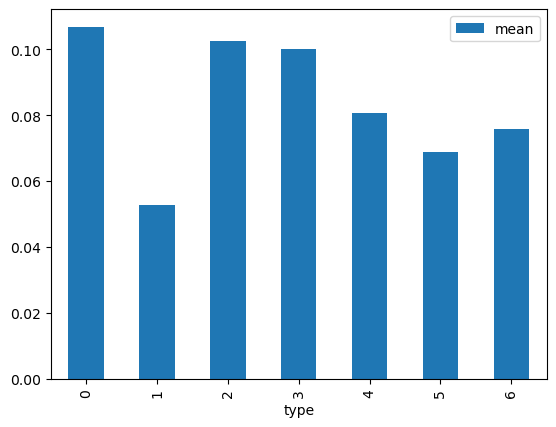

In [88]:
pv_typologies_df=pv_typologies_df.reset_index()
pv_typologies_df.plot(kind='bar', x="type", y="mean")